In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import time
import itertools
import warnings
warnings.filterwarnings('ignore')

## Data quality check / cleaning / preparation 

### Data cleaning
*By Charlie Lovett*

We created our dataset by accumulating data for singular predictors by country from the WHO website. For each of these individual datasets, we removed unnecessary columns and then merged them all together by country. We then exported this merged dataset as 'merged.csv' to use to create our model. For the sake of simplicity, we have not included the code that we used to clean all of our predictors, but the following code offers an example of the cleaning that was done on one dataset (beer as a share of alcohol consumption for each country).

In [20]:
beershare = pd.read_csv("Datasets/beer-as-share-alcohol-consumption.csv")
beershare.head()

,Entity,Code,Year,"Indicator:Alcohol, consumption of pure alcohol by type of beverage (%) - Beverage Types:Beer"
0,Albania,ALB,2016,34.3
1,Algeria,DZA,2016,57.3
2,Andorra,AND,2016,34.1
3,Angola,AGO,2016,70.3
4,Antigua and Barbuda,ATG,2016,33.0


In [21]:
beershare = beershare.rename(columns = {"Indicator:Alcohol, consumption of pure alcohol by type of beverage (%) - Beverage Types:Beer": "beer_as_share_alcohol_consumption", "Entity": "Country"})
beershare = beershare.drop(columns = {"Code","Year"})
beershare.head()

,Country,beer_as_share_alcohol_consumption
0,Albania,34.3
1,Algeria,57.3
2,Andorra,34.1
3,Angola,70.3
4,Antigua and Barbuda,33.0


We had a significant number of predictors that contained at least a few missing values. We imputed each of these missing values by using the average value of the predictor.

In [116]:
# Reading and quickly removing unnecessary columns from the merged dataset
train = pd.read_csv('Datasets/merged.csv')
train = train.drop(columns = {'Unnamed: 0.2','Unnamed: 0.1','Unnamed: 0','Country', 'alc_attributed_fraction_deaths','Region'}, index = 182)
train = train.rename(columns = {'too_many_alc_deaths': 'high_risk'})
train = train.fillna(train.mean())

### Data quality check
*By Lainey Neild*

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

In [6]:
# Distribution of all 41 continuous variables in the dataset
train.describe()

,wine_as_share_alcohol_consumption,beer_as_share_alcohol_consumption,spirits_as_share_alcohol_consumption,tot_alcohol_consumption_per_capita_liters,gdp_per_capita,Population,percent_who_have_not_drank_alcohol_in_last_year,perc_life_no_drink,total_alcohol_consumption_per_capita_liters,percent_who_have_drank_alcohol_in_last_year,...,perc_heavy_drinkers_both_sexes,perc_heavy_drinkers_female,perc_heavy_drinkers_male,perc_consume_alc_past12,perc_consume_alc_past12Female,perc_consume_alc_past12Male,perc_dependent,perc_dependent_female,perc_dependent_male,high_risk
count,182.000000,182.000000,182.000000,182.000000,182.000000,1.820000e+02,182.000000,182.000000,182.000000,182.000000,...,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,15.976163,44.012791,28.788953,6.147551,19310.667153,4.119821e+07,60.602857,44.183978,6.044143,39.445402,...,41.386957,21.839752,51.893789,39.180625,29.308750,49.277500,2.301863,0.903106,3.780124,0.285714
std,16.975203,21.535600,22.994596,4.129105,19695.030994,1.467037e+08,22.879124,28.205930,4.194188,22.870560,...,14.301567,11.709954,16.743993,22.189539,20.423363,24.584447,1.639750,0.752192,2.814501,0.453000
min,0.000000,2.300000,0.000000,0.003000,825.205688,8.995800e+04,8.200000,3.400000,0.003000,0.100000,...,1.900000,0.500000,2.300000,0.100000,0.100000,0.200000,0.100000,0.000000,0.200000,0.000000
25%,2.250000,30.575000,11.300000,2.385000,4524.140869,2.509549e+06,42.175000,18.000000,2.152500,22.450000,...,36.900000,16.075000,46.575000,23.750000,13.925000,33.650000,0.950000,0.200000,1.650000,0.000000
50%,9.050000,43.200000,26.200000,6.147551,12587.102051,9.597430e+06,62.750000,41.850000,5.825000,37.800000,...,41.386957,21.839752,52.700000,39.180625,26.550000,49.277500,2.301863,0.800000,3.790062,0.000000
75%,25.550000,56.475000,41.850000,9.550000,27305.848145,3.350258e+07,77.550000,66.325000,9.550000,57.825000,...,47.375000,25.050000,60.275000,54.675000,40.775000,68.500000,2.900000,1.400000,4.900000,1.000000
max,80.200000,100.000000,97.300000,18.350000,113182.726562,1.393715e+09,99.900000,99.500000,18.350000,91.800000,...,88.100000,79.100000,94.300000,91.800000,87.700000,95.800000,11.000000,3.800000,19.600000,1.000000


<AxesSubplot:xlabel='high_risk', ylabel='count'>

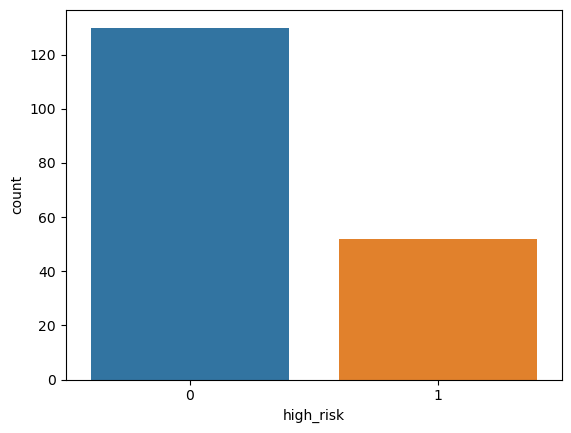

In [8]:
# Visualize the distribution of observations that do / don't classify as high risk for alcohol related mortality
sns.countplot(data=train, x='high_risk')

### Data preparation
*By Jacob Muriel*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. We first created our response variable artificially. We did this by classifying observations with alcohol attributable mortality rates greater than 6% as high risk. This value was determined based on information from the WHO website.

2. We shuffled our dataset to prepare for K-fold cross validation. Since we have population data in this case, K-fold CV will help us to analyze whether the model that we generate is better than a naive model that uses all of the predictors.

In [3]:
# Creating our response variable
train['high_risk'] = train['alc_attributed_fraction_deaths'].apply(lambda x: 1 if x>6 else 0)

In [117]:
# Shuffling the dataset for K-fold CV
train = train.sample(frac=1)
train.head()

,wine_as_share_alcohol_consumption,beer_as_share_alcohol_consumption,spirits_as_share_alcohol_consumption,tot_alcohol_consumption_per_capita_liters,gdp_per_capita,Population,percent_who_have_not_drank_alcohol_in_last_year,perc_life_no_drink,total_alcohol_consumption_per_capita_liters,percent_who_have_drank_alcohol_in_last_year,...,perc_heavy_drinkers_both_sexes,perc_heavy_drinkers_female,perc_heavy_drinkers_male,perc_consume_alc_past12,perc_consume_alc_past12Female,perc_consume_alc_past12Male,perc_dependent,perc_dependent_female,perc_dependent_male,high_risk
126,28.1,55.6,16.4,11.64,23878.171875,19906078.0,32.8,13.5,11.64,67.2,...,51.7,31.2,67.2,67.2,55.5,80.1,1.3,0.6,2.0,1
23,2.7,18.0,5.0,11.83,1925.332031,18718022.0,63.1,58.5,11.83,36.9,...,46.3,22.5,57.5,36.9,23.2,51.2,0.7,0.0,1.4,0
98,15.4,53.9,30.8,3.94,19897.474609,1293159.0,68.8,45.9,3.94,31.2,...,32.4,13.3,41.3,31.2,19.5,43.4,1.9,0.6,3.3,0
89,1.8,9.4,88.2,5.70,1630.584351,4612330.0,69.2,63.7,5.70,30.8,...,41.3,18.7,51.3,30.8,18.9,42.7,1.8,0.5,3.1,0
106,9.8,22.4,67.7,4.41,3663.142334,51483956.0,72.9,50.1,4.41,27.1,...,33.4,13.8,42.5,27.1,16.5,38.3,0.7,0.2,1.3,1


## Exploratory data analysis
*By Charlie Lovett and Jack Troxel*

In [73]:
# Examine which predictors are most strongly correlated with the response variable
train.corrwith(train.high_risk).sort_values(ascending = False)

high_risk                                          1.000000
tot_alcohol_consumption_per_capita_liters          0.447922
daly_alc_use_disorders__all_ages_standardized      0.402697
daly_alc_use_disorders_15_49                       0.399031
perc_heavy_drinkers_male                           0.398390
perc_heavy_drinkers_both_sexes                     0.392347
share_alc_use_disorders_both_sexes                 0.382273
prev_alc_use_disorders_age_70                      0.377033
perc_dependent_male                                0.358100
prev_alc_use_disorders_all_ages                    0.341563
perc_dependent                                     0.336831
prev_alc_use_disorders_age_30_34                   0.315213
prev_alc_use_disorders_age_standardized            0.308772
daly_alc_use_disorders_70                          0.298798
prev_alc_use_disorders_age_15_49                   0.288511
perc_consume_alc_past12Male                        0.252372
prev_alc_use_disorders_age_25_29        

Text(0.5, 0, 'prev_alc_use_disorders_age_50_69')

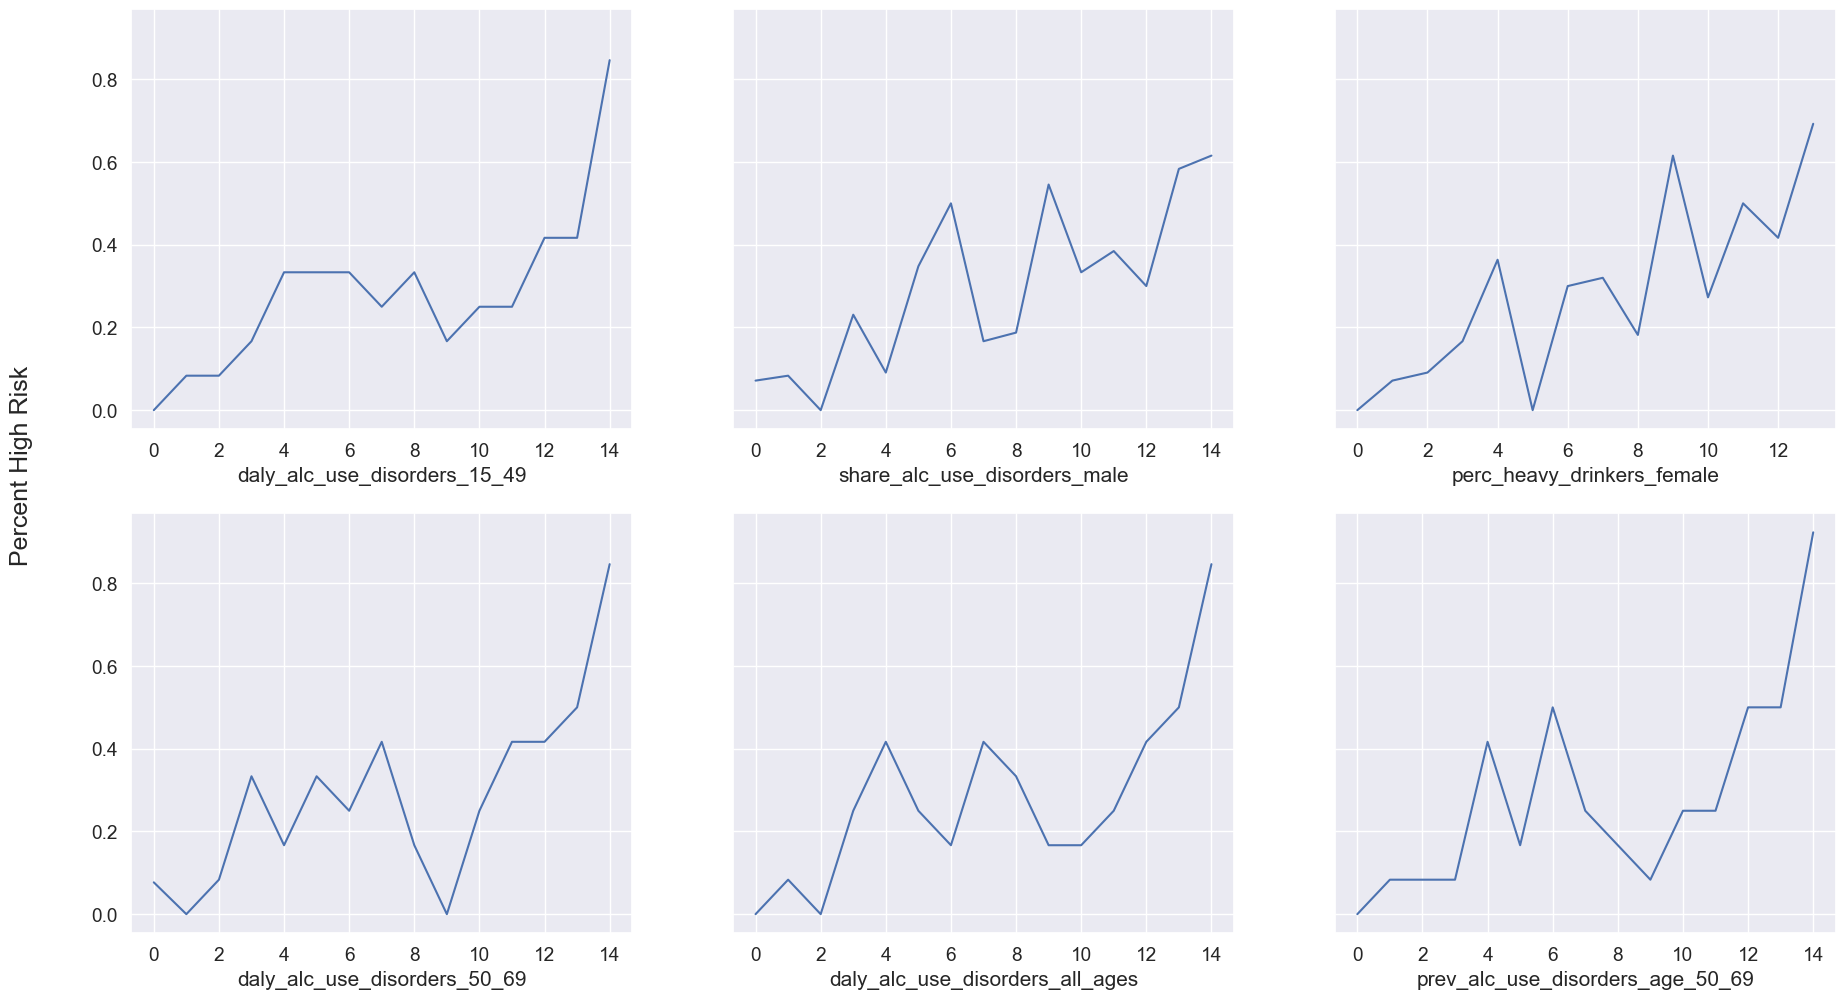

In [100]:
# For the 6 most correlated predictors, examine the relationship between a binned version of each
# of these variables and the response variable to determine any possible transformations

fig, axes = plt.subplots(2,3,figsize=(22,12),sharey=True)
fig.text(0.07, 0.5, 'Percent High Risk', va='center', rotation='vertical')

#1
binned1 = pd.qcut(train['daly_alc_use_disorders_15_49'],15,retbins=True)
train['daly_alc_use_disorders_15_491'] = binned1[0]
new_data = train.groupby('daly_alc_use_disorders_15_491')['high_risk'].agg([('hi_percent','mean'),('nobs','count')]).reset_index(drop=False)
ax = sns.lineplot(ax=axes[0,0], x=new_data.index, y= new_data['hi_percent'])
axes[0,0].set_xlabel('daly_alc_use_disorders_15_49')
axes[0,0].set_ylabel('')


#2
binned2 = pd.qcut(train['share_alc_use_disorders_male'],15,retbins=True)
train['share_alc_use_disorders_male'] = binned2[0]
new_data = train.groupby('share_alc_use_disorders_male')['high_risk'].agg([('hi_percent','mean'),('nobs','count')]).reset_index(drop=False)
ax = sns.lineplot(ax=axes[0,1], x=new_data.index, y= new_data['hi_percent'])
axes[0,1].set_xlabel('share_alc_use_disorders_male')

#3
binned3 = pd.qcut(train['perc_heavy_drinkers_female'],15,retbins=True,duplicates='drop')
train['perc_heavy_drinkers_female'] = binned3[0]
new_data = train.groupby('perc_heavy_drinkers_female')['high_risk'].agg([('hi_percent','mean'),('nobs','count')]).reset_index(drop=False)
ax = sns.lineplot(ax=axes[0,2], x=new_data.index, y= new_data['hi_percent'])
axes[0,2].set_xlabel('perc_heavy_drinkers_female')

#4
binned4 = pd.qcut(train['daly_alc_use_disorders_50_69'],15,retbins=True)
train['daly_alc_use_disorders_50_69'] = binned4[0]
new_data = train.groupby('daly_alc_use_disorders_50_69')['high_risk'].agg([('hi_percent','mean'),('nobs','count')]).reset_index(drop=False)
ax = sns.lineplot(ax=axes[1,0], x=new_data.index, y= new_data['hi_percent'])
axes[1,0].set_xlabel('daly_alc_use_disorders_50_69')
axes[1,0].set_ylabel('')

#5
binned5 = pd.qcut(train['daly_alc_use_disorders_all_ages'],15,retbins=True)
train['daly_alc_use_disorders_all_ages'] = binned5[0]
new_data = train.groupby('daly_alc_use_disorders_all_ages')['high_risk'].agg([('hi_percent','mean'),('nobs','count')]).reset_index(drop=False)
ax = sns.lineplot(ax=axes[1,1], x=new_data.index, y= new_data['hi_percent'])
axes[1,1].set_xlabel('daly_alc_use_disorders_all_ages')

#6
binned6 = pd.qcut(train['prev_alc_use_disorders_age_50_69'],15,retbins=True)
train['prev_alc_use_disorders_age_50_69'] = binned6[0]
new_data = train.groupby('prev_alc_use_disorders_age_50_69')['high_risk'].agg([('hi_percent','mean'),('nobs','count')]).reset_index(drop=False)
ax = sns.lineplot(ax=axes[1,2], x=new_data.index, y= new_data['hi_percent'])
axes[1,2].set_xlabel('prev_alc_use_disorders_age_50_69')

## Developing the model
*By Jack Troxel and Charlie Lovett*

Splitting up the train data into 10 equal-sized subsets

*We chose to do this so that we can use K-Fold CV to test our models*

In [118]:
train0 = train.iloc[0:18,:]
train1 = train.iloc[18:36,:]
train2 = train.iloc[36:54,:]
train3 = train.iloc[54:72,:]
train4 = train.iloc[72:90,:]
train5 = train.iloc[90:108,:]
train6 = train.iloc[108:126,:]
train7 = train.iloc[126:144,:]
train8 = train.iloc[144:163,:]
train9 = train.iloc[163:182,:]

trains = [train0,train1,train2,train3,train4,train5,train6,train7,train8,train9]

In [119]:
#Function to compute confusion matrix and prediction accuracy on test data
def model_results(data,actual_values,model,cutoff=0.5):
    pred_values = model.predict(data)
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = cm[1,0] / (cm[1,0] + cm[1,1])
    return [fnr,accuracy]

### Model Development

#### *(1) A Naive Model*

First, we created a model based solely on the five most correlated predictors with the response variable to create a baseline to compare our future models to. We would have normally created naive model using all of the predictors in the dataset, but given the small number of observations and large number of predictors, K-Fold CV was not functioning on this model, so we settled for only five predictors. This model resulted in an average classification accuracy of 88.5% and an average FNR of 26.2% over the 10 datasets that we used in our K-Fold CV.

In [120]:
naive_model = sm.logit(formula='high_risk~daly_alc_use_disorders_50_69+daly_alc_use_disorders_all_ages+prev_alc_use_disorders_age_50_69+daly_alc_use_disorders__all_ages_standardized+daly_alc_use_disorders_15_49' , data=train).fit()
naive_model.summary()

Optimization terminated successfully.
         Current function value: 0.496127
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              high_risk   No. Observations:                  182
Model:                          Logit   Df Residuals:                      176
Method:                           MLE   Df Model:                            5
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                  0.1707
Time:                        22:58:48   Log-Likelihood:                -90.295
converged:                       True   LL-Null:                       -108.89
Covariance Type:            nonrobust   LLR p-value:                 5.512e-07
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                        -2.2818      0.406     -5.621      0.000      -3.077      -1.486
daly_alc_use_disorders_50_69                      0.0121      0.006      2.041      0.041       0.000       0.024
daly_alc_use_disorders_all_ages                  -0.0141      0.008     -1.658      0.097      -0.031       0.003
prev_alc_use_disorders_age_50_69                  0.3976      0.299      1.329      0.184      -0.189       0.984
daly_alc_use_disorders__all_ages_standardized    -0.0438      0.022     -1.979      0.048      -0.087      -0.000
daly_alc_use_disorders_15_49                      0.0292      0.015      1.967      0.049       0.000       0.058
=================================================================================================================
"""

In [121]:
def naive_k_fold_results():
    total_accuracy=0
    total_fnr=0
    for i in range(len(trains)):
        test = trains[i]
        df = pd.DataFrame()
        for j in range(len(trains)):
            if j != i:
                df = df.append(trains[i])
        naive_model = sm.logit(formula='high_risk~daly_alc_use_disorders_50_69+daly_alc_use_disorders_all_ages+prev_alc_use_disorders_age_50_69+daly_alc_use_disorders__all_ages_standardized+daly_alc_use_disorders_15_49' , data=df).fit(method='bfgs')
        result = model_results(test,test.high_risk,naive_model)
        total_accuracy += result[1]
        total_fnr += result[0]
    print("Average Classification Accuracy: {:.1%}".format(total_accuracy/len(trains)))
    print("Average FNR: {:.1%}".format(total_fnr/len(trains)))
naive_k_fold_results()

         Current function value: 0.282108
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 39
         Current function value: 0.380356
         Iterations: 35
         Function evaluations: 46
         Gradient evaluations: 42
         Current function value: 0.000020
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.306330
         Iterations: 34
         Function evaluations: 40
         Gradient evaluations: 40
         Current function value: 0.128055
         Iterations: 35
         Function evaluations: 48
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 29
         Function evaluations: 37
         Gradient evaluations: 32
         Current function value: 0.180199
         Iterations: 35
         Function evaluations: 46
         Gradient ev

#### *(2) Forward Stepwise Selection Without Interactions*

We began by running forward stepwise selection without interactions to identify the significant predictors in our model. This resulted in a model with 6 predictors, and an average classification accuracy of 87.8% and average FNR of 1.7% over the 10 datasets that we used in our K-Fold CV. Now that we have decreased the number of predictors in our model to 6, we will be able to run forward stepwise selection with interactions to hopefully increase the model effeciency.

In [13]:
columns = train.columns.to_list()
columns.remove('high_risk')
X = train[columns]

def test_accuracy(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    return accuracy

#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate accuracy
    model = sm.logit('high_risk~' + '+'.join(predictor_subset),data = train).fit(method='bfgs')
    accuracy = test_accuracy(train,train.high_risk,model)
    return {"model":model, "accuracy":accuracy}

#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['accuracy'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 3 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest accuracy
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["accuracy"])
    plt.xlabel('# Predictors')
    plt.ylabel('accuracy')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
    
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest accuracy
    best_model = models.loc[models['accuracy'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def forward_selection():
    models_best = pd.DataFrame(columns=["accuracy", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [14]:
models_best = forward_selection()

Optimization terminated successfully.
         Current function value: 0.595666
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.598235
         Iterations: 12
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.594433
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.494554
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.595218
         Iterations: 10
         Function evaluations: 25
         Gradient evaluations: 14
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
Optimizati

Optimization terminated successfully.
         Current function value: 0.488193
         Iterations: 17
         Function evaluations: 29
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.518623
         Iterations: 14
         Function evaluations: 27
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.516690
         Iterations: 14
         Function evaluations: 27
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.502289
         Iterations: 16
         Function evaluations: 27
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.518901
         Iterations: 14
         Function evaluations: 26
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: 0.492269
         Iterations: 16
         Function evaluations: 27
  

Optimization terminated successfully.
         Current function value: 0.449965
         Iterations: 21
         Function evaluations: 33
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.449622
         Iterations: 21
         Function evaluations: 32
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.448157
         Iterations: 21
         Function evaluations: 32
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 0.449600
         Iterations: 24
         Function evaluations: 35
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.445529
         Iterations: 21
         Function evaluations: 32
         Gradient evaluations: 24
Processed  37 models on 3 predictors in 0.35410094261169434 seconds.
Optimization terminated successfully.
         Current function value: 

Optimization terminated successfully.
         Current function value: 0.441423
         Iterations: 28
         Function evaluations: 39
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: 0.443732
         Iterations: 28
         Function evaluations: 39
         Gradient evaluations: 33
         Current function value: 0.430975
         Iterations: 35
         Function evaluations: 46
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 0.443803
         Iterations: 29
         Function evaluations: 40
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 0.443355
         Iterations: 30
         Function evaluations: 41
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.439981
         Iterations: 26
         Function evaluations: 40
         Gradient evaluations: 32
Optimi

         Current function value: 0.355549
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
Optimization terminated successfully.
         Current function value: 0.352075
         Iterations: 31
         Function evaluations: 46
         Gradient evaluations: 35
         Current function value: 0.349019
         Iterations: 35
         Function evaluations: 52
         Gradient evaluations: 41
         Current function value: 0.346704
         Iterations: 35
         Function evaluations: 52
         Gradient evaluations: 41
         Current function value: 0.357073
         Iterations: 35
         Function evaluations: 52
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.357807
         Iterations: 32
         Function evaluations: 49
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.357203
         Iterations: 32
         Functio

         Current function value: 0.336948
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.343501
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.339086
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 38
         Current function value: 0.346369
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 38
         Current function value: 0.347857
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.350035
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.346689
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
Processed  32 models on 8 predictors in 0.5233001708984375 sec

         Current function value: 0.349323
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.351298
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.351079
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.351563
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.348312
         Iterations: 35
         Function evaluations: 52
         Gradient evaluations: 41
         Current function value: 0.347912
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.324869
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.349672
         Iterations:

         Current function value: 0.339523
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.336171
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.340142
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.340529
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.338044
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
Processed  29 models on 11 predictors in 0.5650560855865479 seconds.
         Current function value: 0.319400
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluation

         Current function value: 0.324274
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.303782
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.336397
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.314732
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.311269
         Iterations: 35
         Function evaluations: 52
         Gradient evaluations: 41
         Current function value: 0.316393
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.310858
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.316308
         Iterations:

         Current function value: 0.299058
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.301042
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.294545
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.289658
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.295895
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.308661
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.305580
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.312530
         Iterations:

         Current function value: 0.288550
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.289545
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.288983
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.290546
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.291686
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.293360
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.290628
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.290813
         Iterations:

         Current function value: 0.284505
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.284293
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.292159
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.291589
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.292152
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.293022
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.290037
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.290837
         Iterations:

         Current function value: 0.275110
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.274039
         Iterations: 35
         Function evaluations: 52
         Gradient evaluations: 41
         Current function value: 0.273704
         Iterations: 35
         Function evaluations: 53
         Gradient evaluations: 42
         Current function value: 0.266112
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.269939
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 38
         Current function value: 0.277688
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.278697
         Iterations: 35
         Function evaluations: 52
         Gradient evaluations: 41
Processed  19 models on 21 predictors in 0.5006747245788574 se

         Current function value: 0.275864
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.275560
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.276180
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.275354
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.274637
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.270862
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.270460
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.262780
         Iterations:

         Current function value: 0.270699
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.272896
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.272385
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.273533
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.274515
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.268930
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.268684
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.260887
         Iterations:

         Current function value: 0.269485
         Iterations: 35
         Function evaluations: 52
         Gradient evaluations: 41
         Current function value: 0.266007
         Iterations: 35
         Function evaluations: 52
         Gradient evaluations: 41
         Current function value: 0.265859
         Iterations: 35
         Function evaluations: 52
         Gradient evaluations: 41
         Current function value: 0.258873
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.262587
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.270724
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.271224
         Iterations: 35
         Function evaluations: 52
         Gradient evaluations: 41
Processed  9 models on 31 predictors in 0.3164510726928711 sec

         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
         Current function value: 0.219417
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 38
Processed  2 models on 38 predictors in 0.08989620208740234 seconds.
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
Processed  1 models on 39 predictors in 0.0364990234375 seconds.
Total elapsed time: 16.325733184814453 seconds.


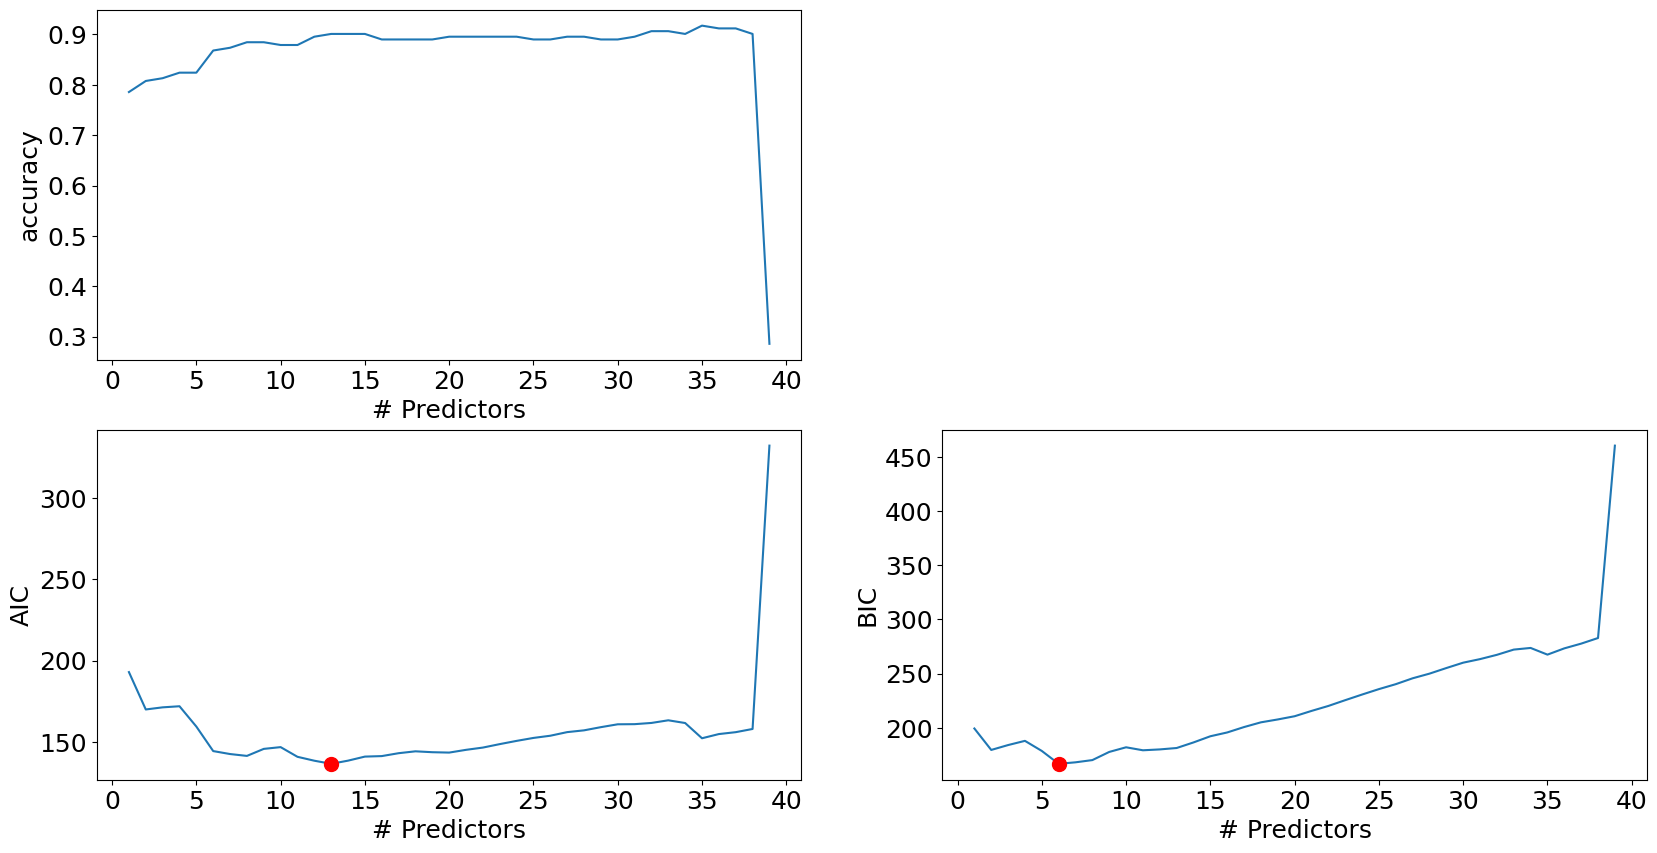

In [15]:
best_sub_plots()

In [16]:
# Development of the forward stepwise selection model w/o interactions
best_fwd_reg_model = models_best['model'][6]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              high_risk   No. Observations:                  182
Model:                          Logit   Df Residuals:                      175
Method:                           MLE   Df Model:                            6
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                  0.4019
Time:                        21:55:53   Log-Likelihood:                -65.126
converged:                       True   LL-Null:                       -108.89
Covariance Type:            nonrobust   LLR p-value:                 9.923e-17
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                        -8.3975      1.711     -4.907      0.000     -11.752      -5.043
daly_alc_use_disorders__all_ages_standardized     0.0039      0.001      2.741      0.006       0.001       0.007
perc_heavy_drinkers_both_sexes                    0.0655      0.026      2.530      0.011       0.015       0.116
beer_as_share_alcohol_consumption                 0.0209      0.012      1.684      0.092      -0.003       0.045
spirits_as_share_alcohol_consumption              0.0257      0.011      2.278      0.023       0.004       0.048
total_alcohol_consumption_per_capita_liters       0.4220      0.093      4.552      0.000       0.240       0.604
gdp_per_capita                                -6.527e-05   1.94e-05     -3.359      0.001      -0.000   -2.72e-05
=================================================================================================================
"""

In [18]:
def forward_k_fold_results():
    total_accuracy=0
    total_fnr=0
    for i in range(len(trains)):
        test = trains[i]
        df = pd.DataFrame()
        for j in range(len(trains)):
            if j != i:
                df = df.append(trains[i])
        forward_model = sm.logit(formula='high_risk~daly_alc_use_disorders__all_ages_standardized+perc_heavy_drinkers_both_sexes+beer_as_share_alcohol_consumption+spirits_as_share_alcohol_consumption+total_alcohol_consumption_per_capita_liters+gdp_per_capita',data= df).fit(method='bfgs')
        result = model_results(test,test.high_risk,forward_model)
        total_accuracy += result[1]
        total_fnr += result[0]
    print("Average Classification Accuracy: {:.1%}".format(total_accuracy/len(trains)))
    print("Average FNR: {:.1%}".format(total_fnr/len(trains)))
forward_k_fold_results()

         Current function value: 0.000002
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 39
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 39
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
         Current function value: 0.000002
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 39
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 40
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 39
         Current function value: 0.265587
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.693147
         Iterations: 0

#### *(3) Forward Stepwise Selection with Interactions*

We next ran forward stepwise selection with interaction terms on the six predictors that we selected from our original round of forward stepwise selection. Although it would have been more ideal to run forward selection with interaction on all 37 predictors, this would have taken far too much time and computing power. After including these interaction terms, our model achieved an average classification accuracy of 88.3% and an average FNR of 2.0% over the 10 datasets that we used in our K-fold CV. Next, we will try to include transformations to the predictors in our model to further improve the model efficiency.

In [60]:
#Creating a dataframe with all the predictors from forward stepwise selection
X = train[['daly_alc_use_disorders__all_ages_standardized', 'perc_heavy_drinkers_both_sexes', 'beer_as_share_alcohol_consumption','spirits_as_share_alcohol_consumption','total_alcohol_consumption_per_capita_liters','gdp_per_capita']]
#Since 'X' will change when we include interactions, we need a backup containing all individual predictors
X_backup = train[['daly_alc_use_disorders__all_ages_standardized', 'perc_heavy_drinkers_both_sexes', 'beer_as_share_alcohol_consumption','spirits_as_share_alcohol_consumption','total_alcohol_consumption_per_capita_liters','gdp_per_capita']]

In [61]:
#Including 2-factor interactions of predictors in train and 'X'. Note that we need train to develop the model, and X to 
#find 'k' variable subsets from amongst all the predictors under consideration
for combo in itertools.combinations(X_backup.columns, 2):    
    train['_'.join(combo)] = train[combo[0]]*train[combo[1]]
    X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)] 

In [62]:
models_best = forward_selection()

Optimization terminated successfully.
         Current function value: 0.518916
         Iterations: 11
         Function evaluations: 23
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.520335
         Iterations: 11
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.598235
         Iterations: 12
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.594433
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.489519
         Iterations: 7
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.595218
         Iterations: 10
         Function evaluations: 25
   

         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
Processed  19 models on 3 predictors in 0.15683698654174805 seconds.
Optimization terminated successfully.
         Current function value: 0.444005
         Iterations: 25
         Function evaluations: 35
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 0.443867
         Iterations: 25
         Function evaluations: 36
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 0.408083
         Iterations: 21
         Function evaluations: 32
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 0.437060
         Iterations: 25
         Function evaluations: 40
         Gradient evaluations: 29
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gra

Optimization terminated successfully.
         Current function value: 0.360841
         Iterations: 34
         Function evaluations: 49
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.358307
         Iterations: 33
         Function evaluations: 47
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.360265
         Iterations: 32
         Function evaluations: 47
         Gradient evaluations: 36
         Current function value: 0.360819
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
         Current function value: 0.353719
         Iterations: 35
         Function evaluations: 52
         Gradient evaluations: 41
         Current function value: 0.693147
         Iterations: 0
         Function e

         Current function value: 0.351938
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.352485
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
         Current function value: 0.352611
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
         Current function value: 0.348282
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.351714
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39
         Current function value: 0.693147
         Iterations: 0
 

         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
Processed  7 models on 15 predictors in 0.14858412742614746 seconds.
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
         Current function value: 0.340800
         Iterations: 35
         Function evaluations: 54
         Gradient evaluations: 43
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
Proce

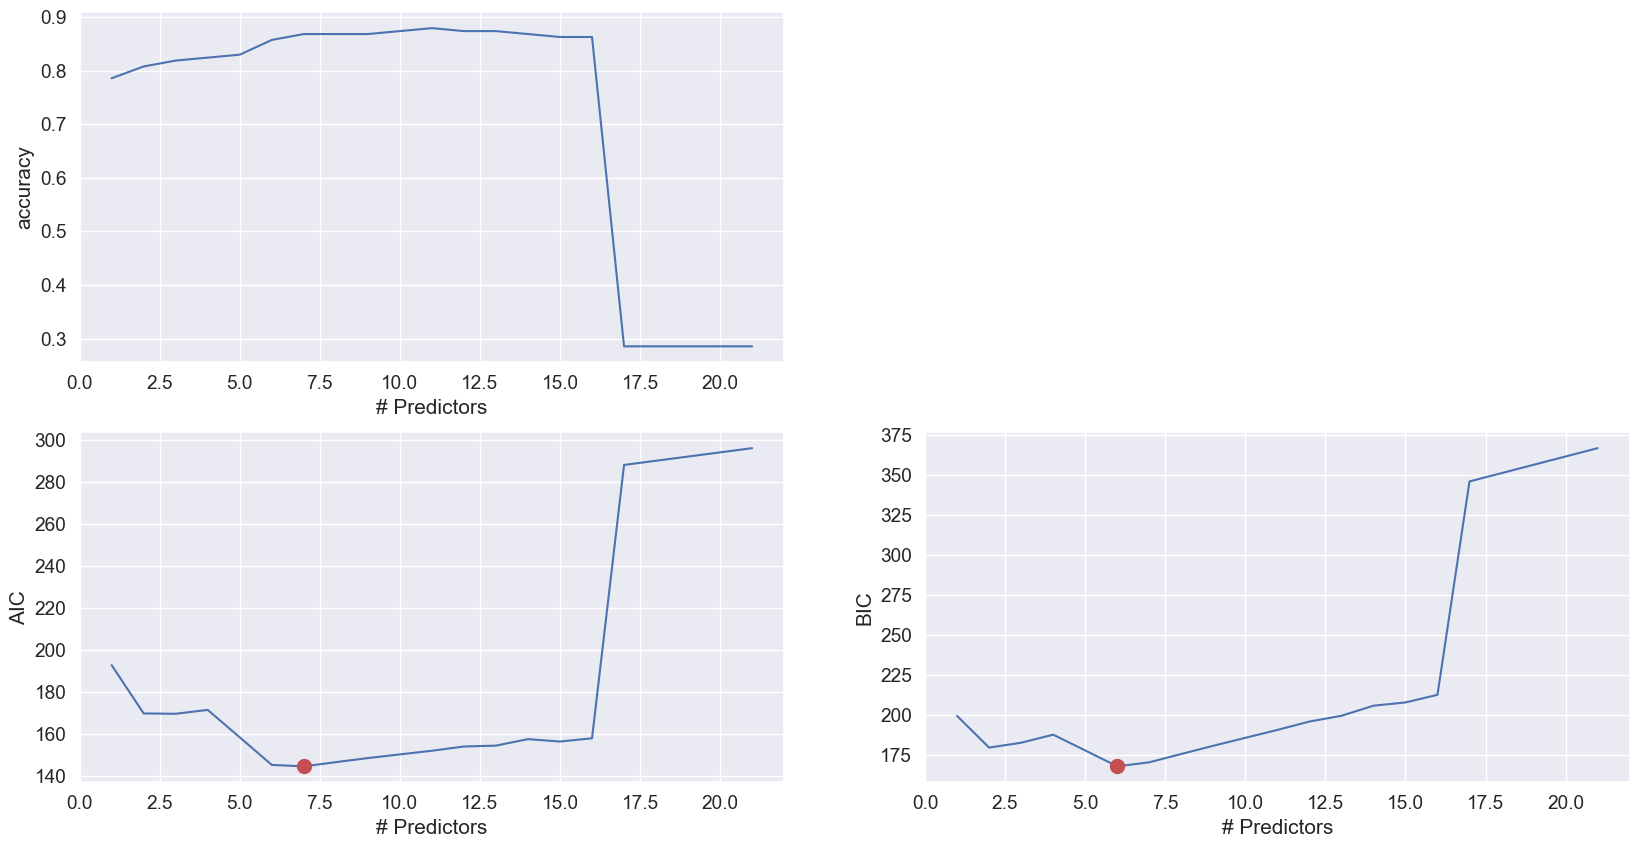

In [63]:
best_sub_plots()

In [64]:
best_fwd_reg_model = models_best['model'][6]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              high_risk   No. Observations:                  182
Model:                          Logit   Df Residuals:                      175
Method:                           MLE   Df Model:                            6
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                  0.3969
Time:                        22:39:10   Log-Likelihood:                -65.673
converged:                       True   LL-Null:                       -108.89
Covariance Type:            nonrobust   LLR p-value:                 1.673e-16
==============================================================================================================================================
                                                                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                     -4.4767      1.745     -2.565      0.010      -7.897      -1.056
daly_alc_use_disorders__all_ages_standardized                                  0.0041      0.001      2.972      0.003       0.001       0.007
perc_heavy_drinkers_both_sexes                                                 0.0118      0.036      0.327      0.744      -0.059       0.083
perc_heavy_drinkers_both_sexes_spirits_as_share_alcohol_consumption            0.0006      0.001      0.461      0.645      -0.002       0.003
spirits_as_share_alcohol_consumption                                          -0.0091      0.058     -0.159      0.874      -0.122       0.104
perc_heavy_drinkers_both_sexes_total_alcohol_consumption_per_capita_liters     0.0078      0.002      4.430      0.000       0.004       0.011
gdp_per_capita                                                             -5.684e-05   1.76e-05     -3.227      0.001   -9.14e-05   -2.23e-05
==============================================================================================================================================
"""

In [65]:
def forward_w_interactions_k_fold_results():
    total_accuracy=0
    total_fnr=0
    for i in range(len(trains)):
        test = trains[i]
        df = pd.DataFrame()
        for j in range(len(trains)):
            if j != i:
                df = df.append(trains[i])
        forward_model_w_interactions = sm.logit(formula='high_risk~daly_alc_use_disorders__all_ages_standardized+perc_heavy_drinkers_both_sexes+perc_heavy_drinkers_both_sexes*spirits_as_share_alcohol_consumption+spirits_as_share_alcohol_consumption+perc_heavy_drinkers_both_sexes*total_alcohol_consumption_per_capita_liters+gdp_per_capita',data= df).fit(method='bfgs')
        result = model_results(test,test.high_risk,forward_model_w_interactions)
        total_accuracy += result[1]
        total_fnr += result[0]
    print("Average Classification Accuracy: {:.1%}".format(total_accuracy/len(trains)))
    print("Average FNR: {:.1%}".format(total_fnr/len(trains)))
forward_w_interactions_k_fold_results()

         Current function value: 0.171719
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 40
         Current function value: 0.000038
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 41
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
         Current function value: 0.000011
         Iterations: 35
         Function evaluations: 53
         Gradient evaluations: 43
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 40
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 48
         Gradient evaluations: 38
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 40
         Current function value: 0.693147
         Iterations: 0

#### *(4) An Attempt at Adding Variable Transformations*

Text(0, 0.5, '')

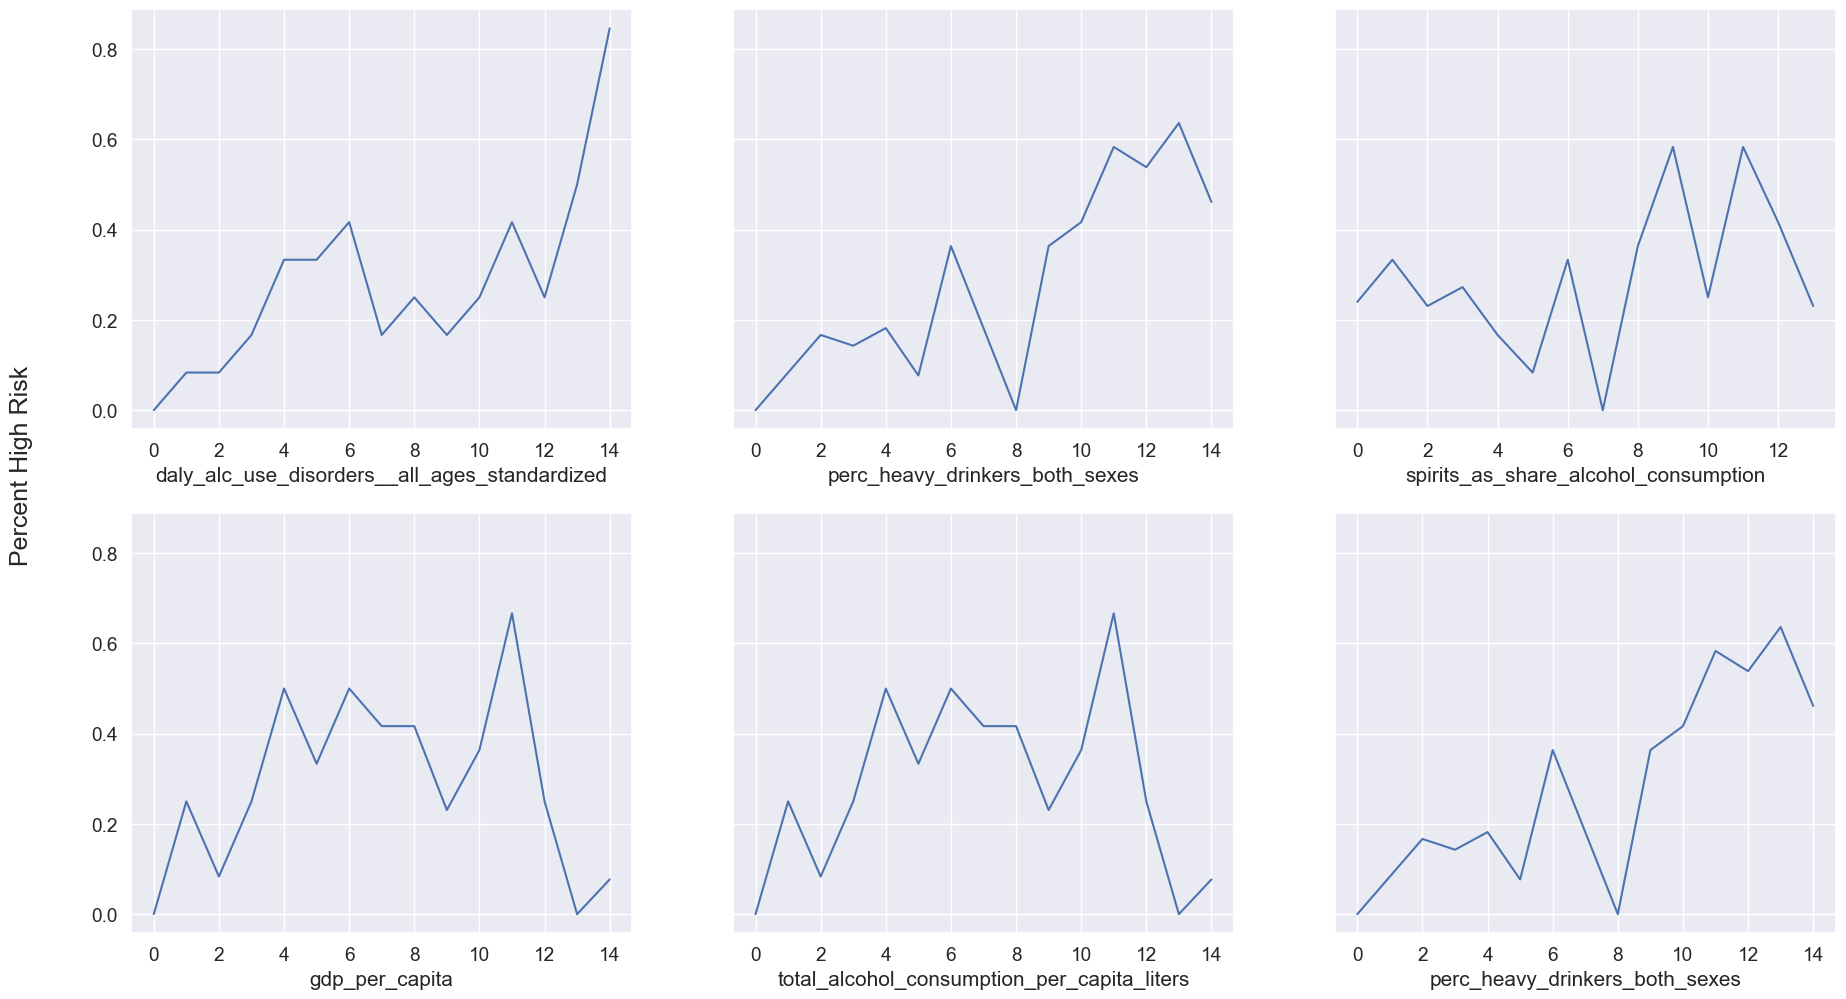

In [66]:
# We did some further EDA on the predictors that we have included up until this point
# in the hopes to find any variable transformations that might be necessary
fig, axes = plt.subplots(2,3,figsize=(22,12),sharey=True)
fig.text(0.07, 0.5, 'Percent High Risk', va='center', rotation='vertical')

#1
binned1 = pd.qcut(train['daly_alc_use_disorders__all_ages_standardized'],15,retbins=True)
train['daly_alc_use_disorders__all_ages_standardized1'] = binned1[0]
new_data = train.groupby('daly_alc_use_disorders__all_ages_standardized1')['high_risk'].agg([('hi_percent','mean'),('nobs','count')]).reset_index(drop=False)
ax = sns.lineplot(ax=axes[0,0], x=new_data.index, y= new_data['hi_percent'])
axes[0,0].set_xlabel('daly_alc_use_disorders__all_ages_standardized')
axes[0,0].set_ylabel('')


#2
binned2 = pd.qcut(train['perc_heavy_drinkers_both_sexes'],15,retbins=True)
train['perc_heavy_drinkers_both_sexes1'] = binned2[0]
new_data = train.groupby('perc_heavy_drinkers_both_sexes1')['high_risk'].agg([('hi_percent','mean'),('nobs','count')]).reset_index(drop=False)
ax = sns.lineplot(ax=axes[0,1], x=new_data.index, y= new_data['hi_percent'])
axes[0,1].set_xlabel('perc_heavy_drinkers_both_sexes')

#3
binned3 = pd.qcut(train['spirits_as_share_alcohol_consumption'],15,retbins=True, duplicates = 'drop')
train['spirits_as_share_alcohol_consumption1'] = binned3[0]
new_data = train.groupby('spirits_as_share_alcohol_consumption1')['high_risk'].agg([('hi_percent','mean'),('nobs','count')]).reset_index(drop=False)
ax = sns.lineplot(ax=axes[0,2], x=new_data.index, y= new_data['hi_percent'])
axes[0,2].set_xlabel('spirits_as_share_alcohol_consumption')

#4
binned4 = pd.qcut(train['gdp_per_capita'],15,retbins=True)
train['gdp_per_capita1'] = binned4[0]
new_data = train.groupby('gdp_per_capita1')['high_risk'].agg([('hi_percent','mean'),('nobs','count')]).reset_index(drop=False)
ax = sns.lineplot(ax=axes[1,0], x=new_data.index, y= new_data['hi_percent'])
axes[1,0].set_xlabel('gdp_per_capita')
axes[1,0].set_ylabel('')

#5
binned5 = pd.qcut(train['total_alcohol_consumption_per_capita_liters'],15,retbins=True)
train['total_alcohol_consumption_per_capita_liters1'] = binned4[0]
new_data = train.groupby('total_alcohol_consumption_per_capita_liters1')['high_risk'].agg([('hi_percent','mean'),('nobs','count')]).reset_index(drop=False)
ax = sns.lineplot(ax=axes[1,1], x=new_data.index, y= new_data['hi_percent'])
axes[1,1].set_xlabel('total_alcohol_consumption_per_capita_liters')
axes[1,1].set_ylabel('')

#6
binned6 = pd.qcut(train['perc_heavy_drinkers_both_sexes'],15,retbins=True)
train['perc_heavy_drinkers_both_sexes1'] = binned6[0]
new_data = train.groupby('perc_heavy_drinkers_both_sexes1')['high_risk'].agg([('hi_percent','mean'),('nobs','count')]).reset_index(drop=False)
ax = sns.lineplot(ax=axes[1,2], x=new_data.index, y= new_data['hi_percent'])
axes[1,2].set_xlabel('perc_heavy_drinkers_both_sexes')
axes[1,2].set_ylabel('')

In [67]:
train['daly_alc_use_disorders__all_ages_standardized2'] = train['daly_alc_use_disorders__all_ages_standardized']*train['daly_alc_use_disorders__all_ages_standardized']
train['daly_alc_use_disorders__all_ages_standardized3'] = train['daly_alc_use_disorders__all_ages_standardized']*train['daly_alc_use_disorders__all_ages_standardized']*train['daly_alc_use_disorders__all_ages_standardized']
train['gdp_per_capita2'] = train['gdp_per_capita']*train['gdp_per_capita']
train['total_alcohol_consumption_per_capita_liters2'] = train['total_alcohol_consumption_per_capita_liters']*train['total_alcohol_consumption_per_capita_liters']
train['perc_heavy_drinkers_both_sexes_spirits_as_share_alcohol_consumption'] = train['perc_heavy_drinkers_both_sexes']*train['spirits_as_share_alcohol_consumption']
train['perc_heavy_drinkers_both_sexes_total_alcohol_consumption_per_capita_liters'] = train['perc_heavy_drinkers_both_sexes']*train['total_alcohol_consumption_per_capita_liters']
X = train[['daly_alc_use_disorders__all_ages_standardized2','daly_alc_use_disorders__all_ages_standardized3','gdp_per_capita2','total_alcohol_consumption_per_capita_liters2','daly_alc_use_disorders__all_ages_standardized','perc_heavy_drinkers_both_sexes','spirits_as_share_alcohol_consumption','total_alcohol_consumption_per_capita_liters','gdp_per_capita','perc_heavy_drinkers_both_sexes_total_alcohol_consumption_per_capita_liters','perc_heavy_drinkers_both_sexes_spirits_as_share_alcohol_consumption']]

In [68]:
models_best=forward_selection()

         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.510131
         Iterations: 10
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.518916
         Iterations: 11
         Function evaluations: 23
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.520335
         Iterations: 11
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.594433
        

Optimization terminated successfully.
         Current function value: 0.395646
         Iterations: 30
         Function evaluations: 41
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.400705
         Iterations: 31
         Function evaluations: 41
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.360842
         Iterations: 31
         Function evaluations: 48
         Gradient evaluations: 37
Processed  6 models on 6 predictors in 0.07753181457519531 seconds.
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
Optimization termina

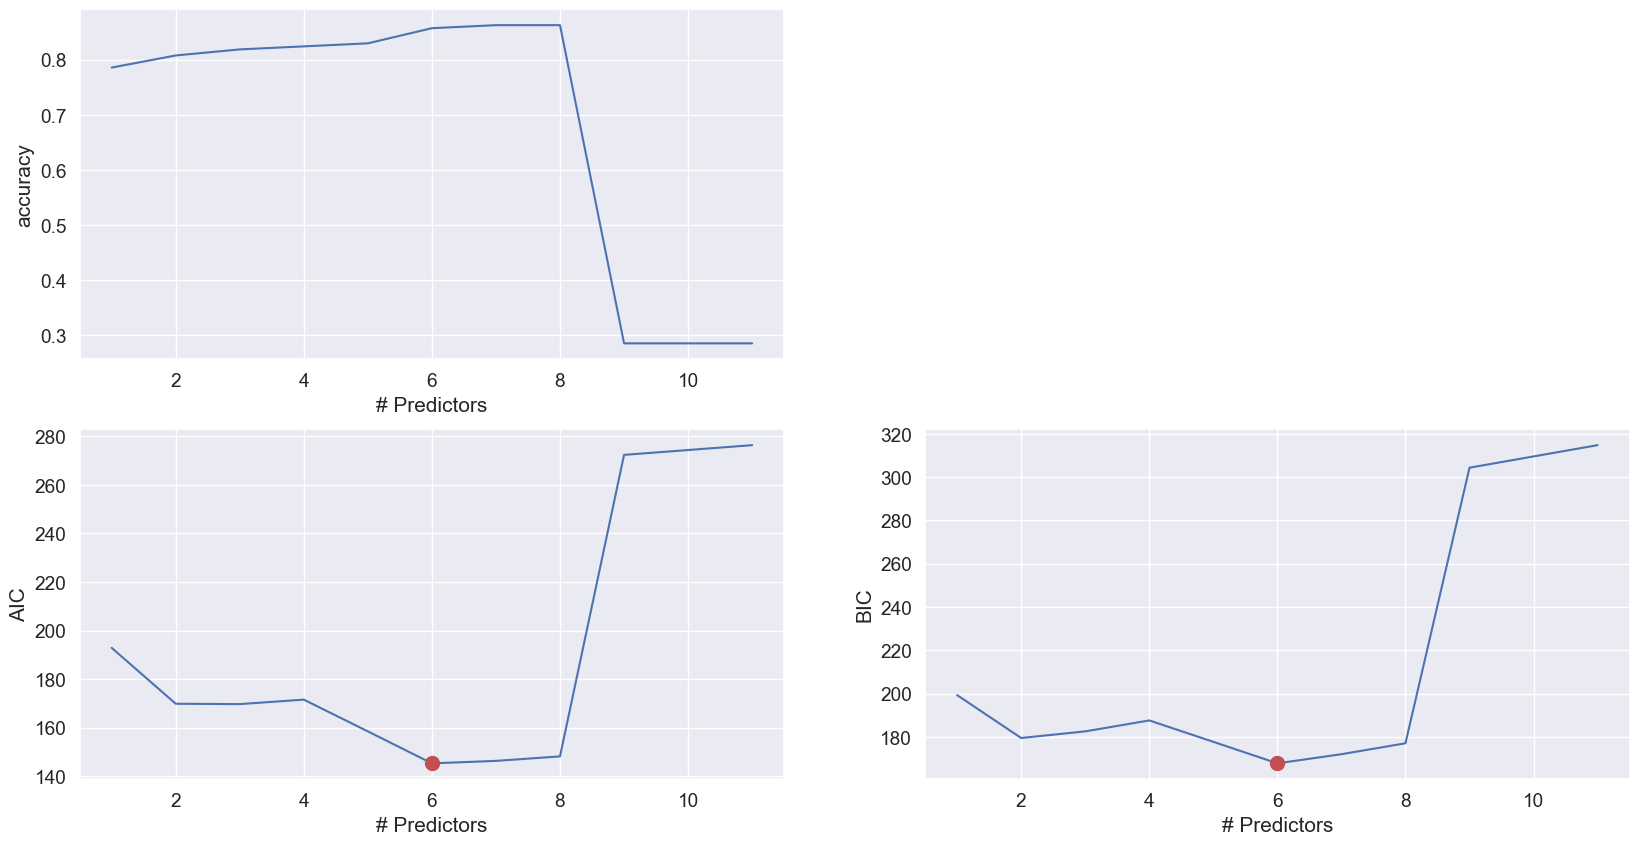

In [69]:
best_sub_plots()

In [70]:
best_transform_model = models_best['model'][6]
best_transform_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              high_risk   No. Observations:                  182
Model:                          Logit   Df Residuals:                      175
Method:                           MLE   Df Model:                            6
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                  0.3969
Time:                        22:39:33   Log-Likelihood:                -65.673
converged:                       True   LL-Null:                       -108.89
Covariance Type:            nonrobust   LLR p-value:                 1.673e-16
==============================================================================================================================================
                                                                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                     -4.4767      1.745     -2.565      0.010      -7.897      -1.056
daly_alc_use_disorders__all_ages_standardized                                  0.0041      0.001      2.972      0.003       0.001       0.007
perc_heavy_drinkers_both_sexes                                                 0.0118      0.036      0.327      0.744      -0.059       0.083
perc_heavy_drinkers_both_sexes_spirits_as_share_alcohol_consumption            0.0006      0.001      0.461      0.645      -0.002       0.003
spirits_as_share_alcohol_consumption                                          -0.0091      0.058     -0.159      0.874      -0.122       0.104
perc_heavy_drinkers_both_sexes_total_alcohol_consumption_per_capita_liters     0.0078      0.002      4.430      0.000       0.004       0.011
gdp_per_capita                                                             -5.684e-05   1.76e-05     -3.227      0.001   -9.14e-05   -2.23e-05
==============================================================================================================================================
"""

#### A note on transformations
Based on the above, when we ran forward stepwise selection on our dataset again, this time including transformations that we thought would be useful based on our EDA, the model did not change. This indicates that there are not (or at least we were not able to find) any specific transformations to improve upon our classification accuracy of 88.3% and FNR of 2.0%. Again, it is possible that there are more efficient models to be found by using best subset selection instead of stepwise selection.

### Code Fitting the Final Model

In [75]:
model = sm.logit(formula='high_risk~daly_alc_use_disorders__all_ages_standardized+perc_heavy_drinkers_both_sexes+perc_heavy_drinkers_both_sexes*spirits_as_share_alcohol_consumption+spirits_as_share_alcohol_consumption+perc_heavy_drinkers_both_sexes*total_alcohol_consumption_per_capita_liters+gdp_per_capita',data= train).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.360802
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              high_risk   No. Observations:                  182
Model:                          Logit   Df Residuals:                      174
Method:                           MLE   Df Model:                            7
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                  0.3969
Time:                        22:43:50   Log-Likelihood:                -65.666
converged:                       True   LL-Null:                       -108.89
Covariance Type:            nonrobust   LLR p-value:                 6.654e-16
==============================================================================================================================================
                                                                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                     -4.2528      2.533     -1.679      0.093      -9.216       0.711
daly_alc_use_disorders__all_ages_standardized                                  0.0041      0.001      2.977      0.003       0.001       0.007
perc_heavy_drinkers_both_sexes                                                 0.0070      0.054      0.131      0.896      -0.098       0.112
spirits_as_share_alcohol_consumption                                          -0.0102      0.058     -0.174      0.862      -0.124       0.104
perc_heavy_drinkers_both_sexes:spirits_as_share_alcohol_consumption            0.0006      0.001      0.472      0.637      -0.002       0.003
total_alcohol_consumption_per_capita_liters                                   -0.0364      0.300     -0.121      0.903      -0.624       0.551
perc_heavy_drinkers_both_sexes:total_alcohol_consumption_per_capita_liters     0.0085      0.006      1.327      0.184      -0.004       0.021
gdp_per_capita                                                             -5.641e-05   1.79e-05     -3.147      0.002   -9.15e-05   -2.13e-05
==============================================================================================================================================
"""